### Audio Classification Data Inspector, Feature Extraction Document
In this document we will read in our data set:
* read in all our audio data, train and test
* inspect the diversity of the audio data
* Then perform feature extraction and cache as a NPY file for MFCC and Mel-Spectrogram.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import helper
import os

# reproducibility
np.random.seed(42)

### Dataset Read In
In this section we will read in our data set structure which is located in our home holder

```
root:
    kaggle_2018_dataset:
        train:
            wav files for training only, contains catalog.csv
        test:
            wav files for testing our model, contains catalog.csv
        data:
            npy files, feature extraction MFCC and MEL-SPEC
        models:
            trained models
```

In [2]:
# get the data set root directory path
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)

# drop unwanted columns 
train_metadata.drop(['license','freesound_id'], axis=1, inplace=True)
test_metadata.drop(['license','freesound_id'], axis=1, inplace=True)

# display the first 5 rows of both metadatas
helper.display_side_by_side([train_metadata.head(),test_metadata.head()], ['train_metadata', 'test_metadata'])

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1
,fname,label,usage
0,00326aa9.wav,Oboe,Private
1,0038a046.wav,Bass_drum,Private
2,007759c4.wav,Saxophone,Private
3,008afd93.wav,Saxophone,Private


### Visualize Label Distribution 
In this section of the notebook we will display the label distribution i.e number of audio files per class

Minimum samples per category =  94
Maximum samples per category =  300


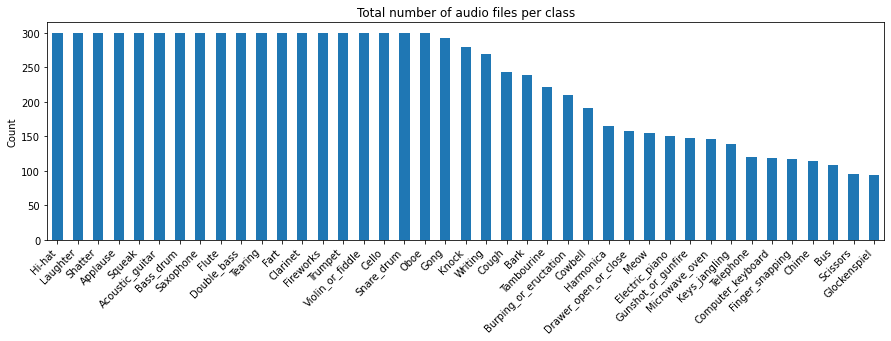

In [3]:
# visualize the label count distribution
plt.figure(figsize=(15,4))
chart = train_metadata['label'].value_counts().plot(kind='bar',)
chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title("Total number of audio files per class")
chart.set_ylabel('Count')

print('Minimum samples per category = ', min(train_metadata['label'].value_counts()))
print('Maximum samples per category = ', max(train_metadata['label'].value_counts()))

### Visualize Verified Label Distribution 
In this section of the notebook we will display how many labels are verified vs not

<AxesSubplot:title={'center':'Verified vs Non-Verified Audio Clips'}>

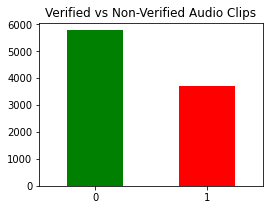

In [4]:
plt.figure(figsize=(4,3))

# plot the number of manually_verified vs non manually_verified audio clips
verified_count = train_metadata['manually_verified'].value_counts()
verified_count.plot(kind='bar', color=['green', 'red'], rot=0, title='Verified vs Non-Verified Audio Clips')


### Read Audio To Memory
This process will take a lot of ram and may vary on dataset size. Atm a 5GB dataset uses roughly 12GB of ram

In [10]:
# Windowing
n_fft=1024
hop_length=None#512

def load_data_set(data_dir, metadata_pd, sample_rate=None, max_duration=2.0, max_samples=None):

    processed_data = []
    sample_rates = []

    print(f"Processing audio from: {data_dir} ... with {len(metadata_pd)} files\nn_fft: {n_fft}\nhop_length: {hop_length}")

    length = len(metadata_pd)
    counter = 0

    # using librosa for every fname in our data_frame generate a mel spectrogram and save it to a numpy array
    for x, row in enumerate(metadata_pd.iloc):
        
        # load the audio file
        y, sr = librosa.load( os.path.join( data_dir, row['fname'] ), sr=sample_rate, duration=max_duration) # we only want 5 seconds of every audio file

        # re sample the audio data to a lower sample rate
        #y_22k = librosa.resample(y, orig_sr=sr, target_sr=22050)

        # normalize the audio with librosa
        normalized_y = librosa.util.normalize(y)

        # append the data to our processed_data array
        processed_data.append(normalized_y)
        sample_rates.append(sr)

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(x+1, length))
            counter = 0

        counter += 1


    print("done")

    print("appending to processed_data as column 'data'")
    # append the processed_data to the data frame as data
    metadata_pd["data"] = processed_data
    print("done")

    print("appending to sample_rates as column 'sr'")
    # append the sample_rates to the data frame as sr
    metadata_pd["sr"] = sample_rates
    print("done")


In [6]:
# load in the train data set
load_data_set(train_dir, train_metadata, max_duration=2.0)

# load in the test data set
load_data_set(test_dir, test_metadata, max_duration=2.0)

Processing audio from: /home/charlesedwards/Documents/kaggle_2018_dataset/train ... with 9473 files
n_fft: 1024
hop_length: None
Status: 501/9473
Status: 1001/9473
Status: 1501/9473
Status: 2001/9473
Status: 2501/9473
Status: 3001/9473
Status: 3501/9473
Status: 4001/9473
Status: 4501/9473
Status: 5001/9473
Status: 5501/9473
Status: 6001/9473
Status: 6501/9473
Status: 7001/9473
Status: 7501/9473
Status: 8001/9473
Status: 8501/9473
Status: 9001/9473
done
appending to processed_data as column 'data'
done
appending to sample_rates as column 'sr'
done
Processing audio from: /home/charlesedwards/Documents/kaggle_2018_dataset/test ... with 1600 files
n_fft: 1024
hop_length: None
Status: 501/1600
Status: 1001/1600
Status: 1501/1600
done
appending to processed_data as column 'data'
done
appending to sample_rates as column 'sr'
done


In [7]:
# display the first 5 rows of both metadatas again as we now have normalized audio data
helper.display_side_by_side([train_metadata.head(),test_metadata.head()], ['train_metadata', 'test_metadata'])

,fname,label,manually_verified,data,sr
0,00044347.wav,Hi-hat,0,[ 0. 0.00139777 -0.0002688 ... 0.03064351 0.01134348 -0.00037632],44100
1,001ca53d.wav,Saxophone,1,[-0.00230576 -0.00223589 -0.00237563 ... -0.31721634 -0.33181944 -0.3596283 ],44100
2,002d256b.wav,Trumpet,0,[ 0. 0. -0.002886 ... -0.002886 -0.001443 0.001443],44100
3,0033e230.wav,Glockenspiel,1,[ 0. 0.00119832 0.00467346 ... -0.01881366 -0.01905333 -0.01905333],44100
4,00353774.wav,Cello,1,[-0.01348507 -0.01262764 -0.01340712 ... 0.46472836 0.46098682 0.4504638 ],44100
,fname,label,usage,data,sr
0,00326aa9.wav,Oboe,Private,[0.00038076 0.00057114 0.00050768 ... 0.00019038 0.00019038 0.00012692],44100
1,0038a046.wav,Bass_drum,Private,[-0.00064803 -0.00083318 -0.00055545 ... 0.0003703 0.00018515 0.00027773],44100
2,007759c4.wav,Saxophone,Private,[-0.00292569 -0.0046811 0.0046811 ... 0.65301347 0.64189583 0.6401404 ],44100
3,008afd93.wav,Saxophone,Private,[ 0.00157873 0.00166182 0.00191109 ... -0.06871624 -0.07793935 -0.08309098],44100


### Data Visualization 1/3
Visualize the train_metadata, in this section generate **STFT** spectrograms to db/log scale

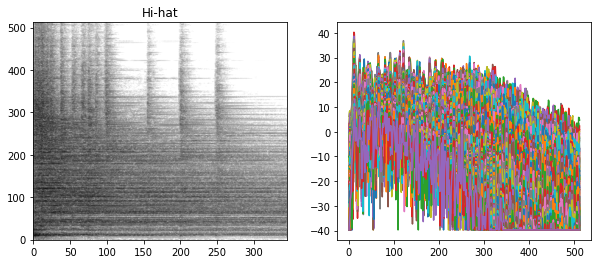

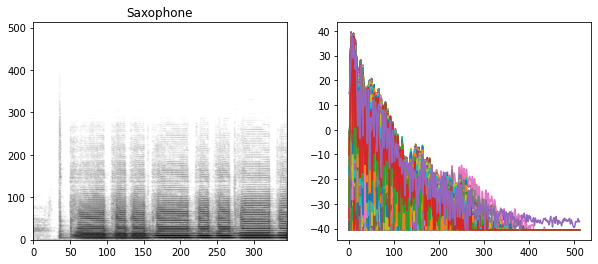

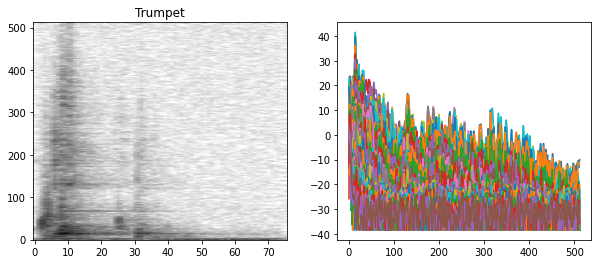

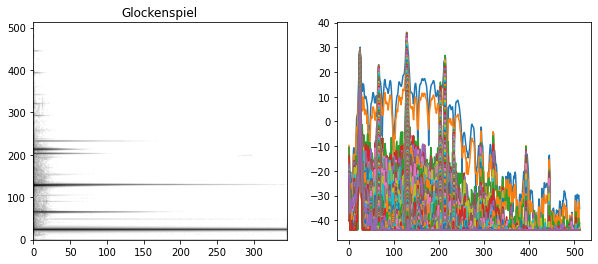

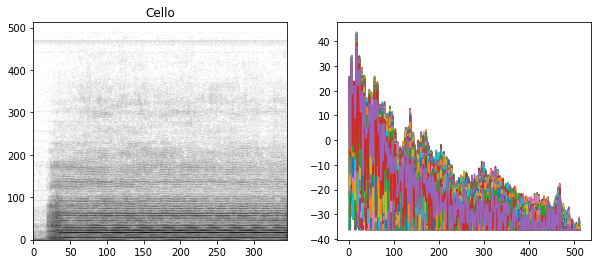

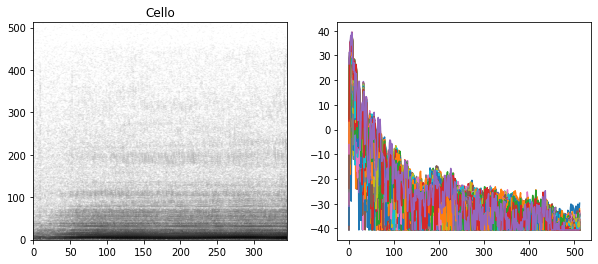

In [11]:
# display 6 random spectrograms
for i in range(6):

    # compute a short-time Fourier transform (STFT)
    D = librosa.stft(train_metadata.iloc[i]['data'], n_fft=n_fft, hop_length=hop_length)
    # convert to db
    D_db = librosa.amplitude_to_db(np.abs(D))

    # display the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(D_db, aspect='auto', origin='lower', cmap='gray_r')
    plt.title(train_metadata.iloc[i]['label'])
    plt.subplot(1, 2, 2)
    plt.plot(D_db)
    plt.show()


### Data Visualization 2/3
Display 6 audio **MFCCs** of the train_metadata,
Mel-frequency cepstral coefficients

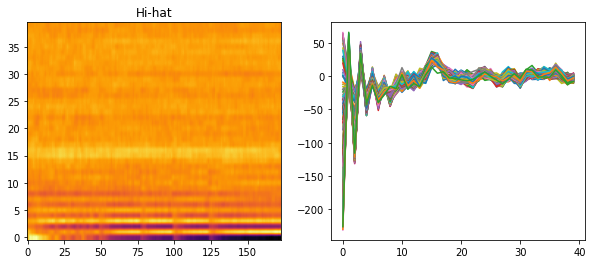

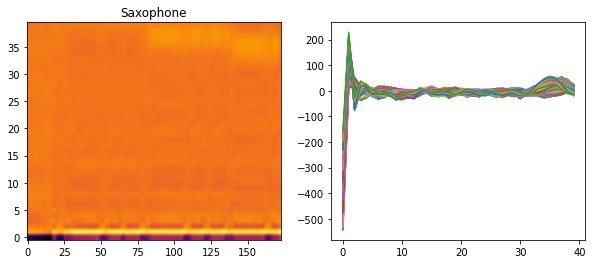

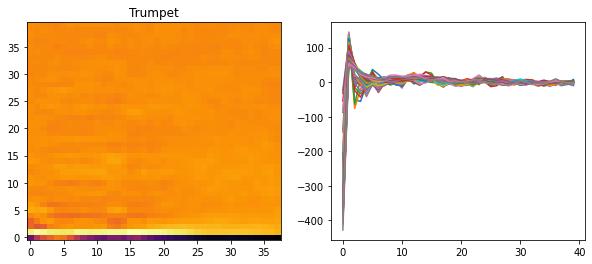

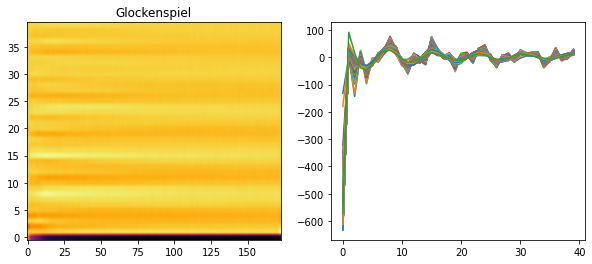

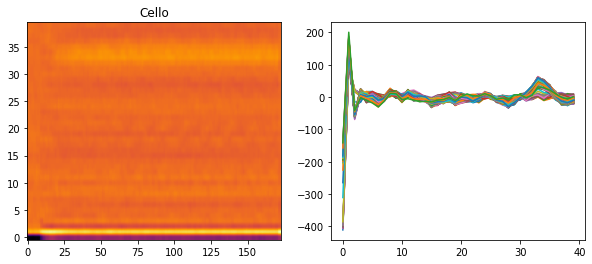

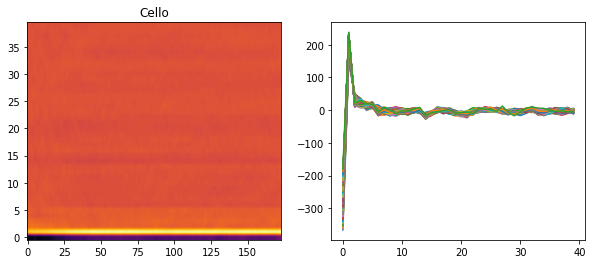

In [13]:
# display 6 random MFCCS
for i in range(6):

    mfcc = librosa.feature.mfcc(train_metadata.iloc[i]['data'], sr=train_metadata.iloc[i]['sr'], n_mfcc=40)

    # display the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap="inferno")
    plt.title(train_metadata.iloc[i]['label'])
    plt.subplot(1, 2, 2)
    plt.plot(mfcc)
    plt.show()

### Data Visualization 3/3
Display 6 audio **MEL-Spectrogram** of the train_metadata

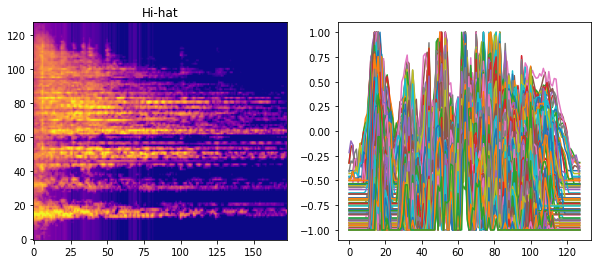

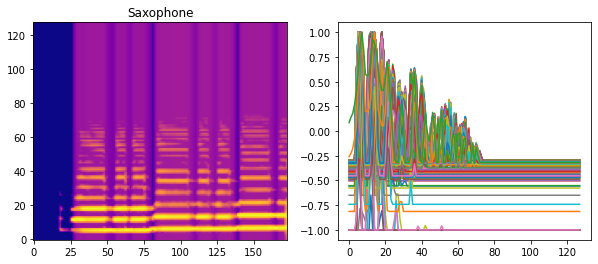

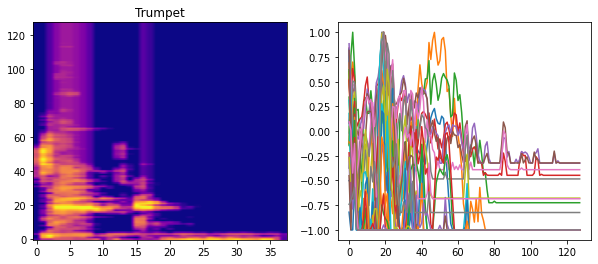

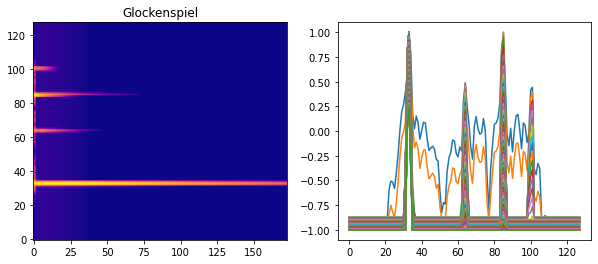

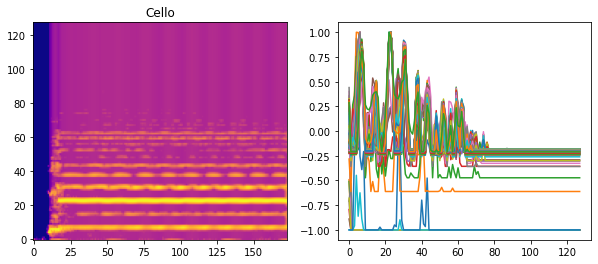

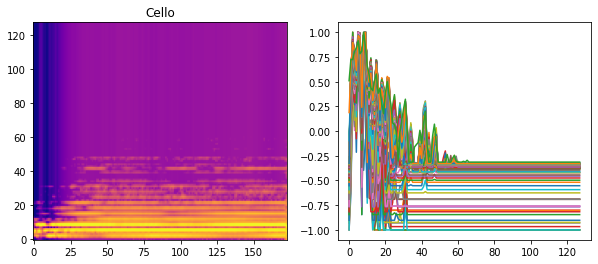

In [14]:
# create MEL-scaled filter banks spectrograms
#n_mels = 128

# display 6 random mel spectrograms
for i in range(6):

    # generate a mel scaled spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(train_metadata.iloc[i]['data'], sr=train_metadata.iloc[i]['sr']) # n_mels=n_mels

    # convert the sound intensity to log scale
    mel_db = librosa.amplitude_to_db(np.abs(mel_spectrogram))

    # normalize the data to 0-1
    normalized_mel = librosa.util.normalize(mel_db)

    # plot the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(normalized_mel, aspect='auto', origin='lower', cmap='plasma')
    plt.title(train_metadata.iloc[i]['label'])
    plt.subplot(1, 2, 2)
    plt.plot(normalized_mel)
    plt.show()


### Begin Feature Extraction For MFCC for train and test datasets
We will cache the feature extraction into npy files of the train and test datasets for training

In [17]:
def extract_mfcc_features(metadata_pd, n_mfcc=40, base_name=None):

    if base_name is None:
        print("base_name is None")
        return

    base_name = 'mfcc-' + base_name

    print(f"Starting Extraction of MFCC features for base name: {base_name} total, {len(metadata_pd)} files")

    # Iterate through all audio files and extract MFCC
    features = []
    labels = []
    frames_max = 0
    counter = 0
    total_samples = len(metadata_pd)
    mfcc_max_padding = 0

    for index, row in metadata_pd.iterrows():
        class_label = row["label"]

        # Extract MFCC data
        mfcc = librosa.feature.mfcc(row['data'], sr=row['sr'], n_mfcc=n_mfcc)
        
        # normalize the mfcc between -1 and 1
        normalized_mfcc = librosa.util.normalize(mfcc)

        # Should we require padding
        shape = normalized_mfcc.shape[1]
        if (mfcc_max_padding > 0 & shape < mfcc_max_padding):
            xDiff = mfcc_max_padding - shape
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            normalized_mfcc = np.pad(normalized_mfcc, pad_width=((0,0), (xLeft, xRight)), mode='constant')

        # Save current frame count
        num_frames = normalized_mfcc.shape[1]
        
        # Add row (feature / label)
        features.append(normalized_mfcc)
        labels.append(class_label)

        # Update frames maximum
        if (num_frames > frames_max):
            frames_max = num_frames

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(index+1, total_samples))
            counter = 0

        counter += 1
        
    print("Finished: {}/{}".format(index, total_samples))
    # Add padding to features with less than frames than frames_max
    padded_features = helper.add_padding(features, frames_max)
    # Verify shapes
    print("Raw features length: {}".format(len(features)))
    print("Padded features length: {}".format(len(padded_features)))
    print("Feature labels length: {}".format(len(labels)))

    # Convert features (X) and labels (y) to Numpy arrays
    X = np.array(padded_features)
    y = np.array(labels)

    data_npy_folder = os.path.join(dataset_root_dir, 'data')

    # Optionally save the features to disk
    np.save( os.path.join(data_npy_folder, f"X-{base_name}" ), X)
    np.save( os.path.join(data_npy_folder, f"y-{base_name}" ), y)

    # free up memory
    del X
    del y
    del features
    del labels
    
    print(f"Finished Extraction of MFCC features for base name: {base_name} total, {len(metadata_pd)} files")

In [18]:
extract_mfcc_features(train_metadata, n_mfcc=40, base_name='train')
extract_mfcc_features(test_metadata, n_mfcc=40, base_name='test')

Starting Extraction of MFCC features for base name: mfcc-train total, 9473 files
Status: 501/9473
Status: 1001/9473
Status: 1501/9473
Status: 2001/9473
Status: 2501/9473
Status: 3001/9473
Status: 3501/9473
Status: 4001/9473
Status: 4501/9473
Status: 5001/9473
Status: 5501/9473
Status: 6001/9473
Status: 6501/9473
Status: 7001/9473
Status: 7501/9473
Status: 8001/9473
Status: 8501/9473
Status: 9001/9473
Finished: 9472/9473
Raw features length: 9473
Padded features length: 9473
Feature labels length: 9473
Finished Extraction of MFCC features for base name: mfcc-train total, 9473 files
Starting Extraction of MFCC features for base name: mfcc-test total, 1600 files
Status: 501/1600
Status: 1001/1600
Status: 1501/1600
Finished: 1599/1600
Raw features length: 1600
Padded features length: 1600
Feature labels length: 1600
Finished Extraction of MFCC features for base name: mfcc-test total, 1600 files


In [19]:
def extract_mel_spectrogram_features(metadata_pd, n_mels=40, base_name=None):

    if base_name is None:
        print("base_name is None")
        return

    base_name = 'mel-' + base_name

    print(f"Starting Extraction of MEL-Spec features for base name: {base_name} total, {len(metadata_pd)} files")

    # Iterate through all audio files and extract mel spectrograms
    features = []
    labels = []
    frames_max = 0
    counter = 0
    total_samples = len(metadata_pd)
    mfcc_max_padding = 0

    for index, row in metadata_pd.iterrows():
        class_label = row["label"]

        # generate a mel scaled spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(row['data'], sr=row['sr'])#, n_mels=n_mels)

        # convert the sound intensity to log scale
        mel_db = librosa.amplitude_to_db(np.abs(mel_spectrogram))

        # normalize the data to 0-1
        normalized_mel = librosa.util.normalize(mel_db)

        # Should we require padding
        shape = normalized_mel.shape[1]
        if (mfcc_max_padding > 0 & shape < mfcc_max_padding):
            xDiff = mfcc_max_padding - shape
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            normalized_mel = np.pad(normalized_mel, pad_width=((0,0), (xLeft, xRight)), mode='constant')

        # Save current frame count
        num_frames = normalized_mel.shape[1]
        
        # Add row (feature / label)
        features.append(normalized_mel)
        labels.append(class_label)

        # Update frames maximum
        if (num_frames > frames_max):
            frames_max = num_frames

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(index+1, total_samples))
            counter = 0

        counter += 1
        
    print("Finished: {}/{}".format(index, total_samples))
    # Add padding to features with less than frames than frames_max
    padded_features = helper.add_padding(features, frames_max)
    # Verify shapes
    print("Raw features length: {}".format(len(features)))
    print("Padded features length: {}".format(len(padded_features)))
    print("Feature labels length: {}".format(len(labels)))

    # Convert features (X) and labels (y) to Numpy arrays
    X = np.array(padded_features)
    y = np.array(labels)

    data_npy_folder = os.path.join(dataset_root_dir, 'data')

    # Optionally save the features to disk
    np.save( os.path.join(data_npy_folder, f"X-{base_name}" ), X)
    np.save( os.path.join(data_npy_folder, f"y-{base_name}" ), y)

    # free up memory
    del X
    del y
    del features
    del labels
    
    print(f"Finished Extraction of MEL-Spec features for base name: {base_name} total, {len(metadata_pd)} files")

In [20]:
extract_mel_spectrogram_features(train_metadata, n_mels=40, base_name='train')
extract_mel_spectrogram_features(test_metadata, n_mels=40, base_name='test')

Starting Extraction of MEL-Spec features for base name: mel-train total, 9473 files
Status: 501/9473
Status: 1001/9473
Status: 1501/9473
Status: 2001/9473
Status: 2501/9473
Status: 3001/9473
Status: 3501/9473
Status: 4001/9473
Status: 4501/9473
Status: 5001/9473
Status: 5501/9473
Status: 6001/9473
Status: 6501/9473
Status: 7001/9473
Status: 7501/9473
Status: 8001/9473
Status: 8501/9473
Status: 9001/9473
Finished: 9472/9473
Raw features length: 9473
Padded features length: 9473
Feature labels length: 9473
Finished Extraction of MEL-Spec features for base name: mel-train total, 9473 files
Starting Extraction of MEL-Spec features for base name: mel-test total, 1600 files
Status: 501/1600
Status: 1001/1600
Status: 1501/1600
Finished: 1599/1600
Raw features length: 1600
Padded features length: 1600
Feature labels length: 1600
Finished Extraction of MEL-Spec features for base name: mel-test total, 1600 files
